# Using NetCDF Python interface for simple remote data access using DAP4

This notebook contains a simple example of how to use the NetCDF Python interface and DAP4 to pull data from remote DAP4 servers into your Python program's memory space so that the data may be analyized and displayed.

We show how to use simple HTTP requests to look at a dataset's metadata and how to use the NetCDF Python package to read data into numpy arrays and plot (or do other things) with those data. NetCDF Python provides lazy evaluation, so data are read only when needed.

This tutorial utilizes the NASA Global High Resolution Sea Surface Temperature from the GOES-16 satellite. You may wish to review the summary on our Tutorial Datasets page before continuing.

To read more about this package, see __[netCDF4](https://unidata.github.io/netcdf4-python/)__ which includes information on OPeNDAP

You can run this tutorial in your browser using Google Colab.<br>

<a target="_blank" href="https://colab.research.google.com/github/OPENDAP/NASA-tutorials/blob/main/tutorials/colab_backup/1.netcdf_tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Contents
[Imports](#Colab-environment-setup-and-imports) Packages you need to read data from the OPeNDAP server<br>
[Opening the remote dataset](#Open-the-remote-dataset-using-the-URL) The initial interaction with the remote dataset<br>
[Looking at a variable](#Looking-at-a-variable) Get attribute information about a specific variable<br>
[Examining dataset dimenions](#Examining-dataset-dimenions) Learn about the overall dataset structure<br>
[Getting useful information about variables](#Getting-useful-information-about-variables) More about variables<br>
[Accessing data](#Accessing-data) Read values in the arrays<br>
[Plotting data](#Plotting-data) This section imports some more packages<br>
[References](#References)<br>

Copyright (C) 2023 OPeNDAP, Inc. This Jupyter Notebook is made available under the Creative Commons Attribution license 4.0.


## Colab Environment Setup and Imports

To use the netCDF4 Python package to read from OPeNDAP servers, including the NASA Cloud-based server, you only need to include the `netCDF4` package. Later in this notebook we will show some plots that use other packages for the graphics.

In [3]:
# Clone into the repository
! git clone -b colab-backup https://github.com/OPENDAP/NASA-tutorials.git
# Use pip3 to install netCDF4 until conda has a version that authenticates with EDL.
! pip3 install netcdf4 earthaccess
# Create dodsrc files
! ./NASA-tutorials/tutorials/setup_dodsrc.sh

import netCDF4

### Tutorial configuration

Set the variables below to switch between data served using the NASA Cloud-based server and the OPeNDAP test server and to toggle verbose output mode.
By default we will use data served from our test server since that does not require authentication. If you want to see those same data from the NASA server
you will need to obtain credentials for NASA's __[Earthdata Login](https://urs.earthdata.nasa.gov/)__ and for the (simple) steps to
__[configure netCDF4](https://opendap.github.io/documentation/tutorials/ClientAuthentication_at.html#_matlab_ferret_other_applications_that_use_netcdf_c)__
to use those.

<div class="alert alert-block alert-info">
    Be sure to start the URL with the <b><tt>dap4:</tt></b> prefix and not the <b><tt>https:</tt></b>
    prefix when using the <b>netCDF4 Python</b> package and accessing data served by 
    NASA's OPeNDAP in the Cloud server. The OPeNDAP in the Cloud server will otherwise 
    send responses that (often) cannot represent some of the variables in the dataset.
</div>

In [25]:
USE_NASA_CLOUD_BASED_DATA = True
VERBOSE = True

# Detect authentication has already happened. This is easy to override.
ALREADY_AUTH = False
import subprocess
# shell exit 0 is 'true'
if not subprocess.call(['bash', './is_authenticated.sh']):
    ALREADY_AUTH = True

if(USE_NASA_CLOUD_BASED_DATA):
    print(f"The netCDF4 library version must be 4.9.0 or be >= 4.9.3 for EDL authentication to work.")
    print(f"The netCDF4 library version is {netCDF4.getlibversion()}")
    if not ALREADY_AUTH:
        import earthaccess
        auth = earthaccess.login(strategy="interactive", persist=True)
        subprocess.call(['bash', './setup_dodsrc.sh'])
    dataset_url = "dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0"
else:
    dataset_url = "dap4://test.opendap.org/opendap/tutorials/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0.nc"

# define 'vprint()'' as print() if VERBOSE is True, otherwise define it as a function that does nothing.
vprint = print if VERBOSE else lambda *a, **k: None

vprint(f"dataset_url: {dataset_url}")

Are you authenticated... yes.
The netCDF4 library version must be 4.9.0 or be >= 4.9.3 for EDL authentication to work.
The netCDF4 library version is 4.8.1 of Jan 25 2023 00:27:43 $
dataset_url: dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0


## Open the remote dataset using the URL

When a URL is passed to the netCDF.Dataset() function, the package will read only descriptive information about the contents of the dataset. If the returned obj ('f' in this example) is printed, we can see that information that includes the data model, file format and dataset attributes.

There is a delay as the information about this dataset is read from the remote site. Fortunately, the whole dataset is not transferred, only the dataset's descriptive information (aka metadata).

Note that at the end of the display, the variables and their dimensions are shown. That's going to be useful!

In [8]:
%%time
f = netCDF4.Dataset(dataset_url, 'r')
print(f"NetCDF4 dataset: {f}") 

NetCDF4 dataset: <class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format DAP4):
    Conventions: CF-1.4
    title: Sea Surface Temperature
    summary: The L3C product derived from GOES16/ABI brightness temperatures.
    references: Geostationary Sea Surface Temperature Product User Manual, http://www.osi-saf.org
    institution: OSISAF
    comment: 
    license: All intellectual property rights of the Ocean &amp; Sea Ice SAF products belong to EUMETSAT. The use of these products is granted to every user, free of charge. If users wish to use these products, EUMETSAT&apos;s copyright credit must be shown by displaying the words &apos;Copyright EUMETSAT&apos; under each of the products shown. EUMETSAT offers no warranty and accepts no liability in respect of the Ocean &amp; Sea Ice SAF products. EUMETSAT neither commits to nor guarantees the continuity, availability, or quality or suitability for any purpose of, the Ocean &amp; Sea Ice SAF products.
    id: GOES16-

## Looking at a variable

Because information about each variable was read during the netCDF4.Dataset() call, the response is fast.

Information about variables in the dataset is held in a Python dictionary named 'variables.' The information for the variable 'lat' is accessed below.

Note that object returned when the `variables` disctionary is used is a `numpy` array, but the actual values are not loaded into that array until requested.

In [9]:
lat = f.variables['lat']
print(f"Latitude: {lat}")

Latitude: <class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    long_name: latitude
    standard_name: latitude
    axis: Y
    units: degrees_north
    valid_min: -90.000046
    valid_max: 90.000015
    comment: geographical coordinates, WGS84 projection
unlimited dimensions: 
current shape = (2400,)
filling on, default _FillValue of 9.969209968386869e+36 used


## Examining dataset dimenions

Sometimes it is handy to know about shared dimensions in a dataset. Use the Python dictionary 'dimensions' for that, as shown below.

In [10]:
for dname, d in f.dimensions.items():
    print(d)


<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1
<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 2400
<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 2400


## Getting useful information about variables

Often it is useful to know the dimensions and shape of variables. Below the shape for the 'lat' and 'sea_surface_temperature' variables are accessed.

In [11]:
lat.dimensions

('lat',)

In [12]:
f.variables['lat'].shape

(2400,)

In [13]:
f.variables['sea_surface_temperature'].shape

(1, 2400, 2400)

## Accessing data

To read the values for one or more variables, use the `variables` dictionary and the array slicing syntax to request the data.
<div class="alert alert-block alert-info">
    This cell reads data values from the remote location and may take a while to run.
<br><br>    Previously, the netCDF4 package read only small amounts of metadata from the remote dataset and each cell
    ran quickly. The amount of time used to read the larger amount of data will depend on the speed of
    the network connection and the current processing load on the data server
</div>
In the cells below, we get the Latitude, Longitude and Sea Surface Temperature data from the remote dataset.

In [14]:
%%time
latitude = f.variables['lat'][:]

checksumhack=0


CPU times: user 1.27 s, sys: 1.69 s, total: 2.96 s
Wall time: 54.2 s


In [15]:
latitude

masked_array(data=[-59.975, -59.925, -59.875, ...,  59.875,  59.925,
                    59.975],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [16]:
longitude = f.variables['lon'][:]

In [17]:
longitude

masked_array(data=[-134.975, -134.925, -134.875, ...,  -15.125,  -15.075,
                    -15.025],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [18]:
%%time
sst = f.variables['sea_surface_temperature'][:]
print(f"Sea Surface Temperature shape: {sst.shape}")
print(f"Sea Surface Temperature: {sst}")

Sea Surface Temperature shape: (1, 2400, 2400)
Sea Surface Temperature: [[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... 288.28 288.28 288.28]
  [-- -- -- ... 286.59999999999997 286.59999999999997 --]]]
CPU times: user 97.6 ms, sys: 19 ms, total: 117 ms
Wall time: 118 ms


## Plotting data

Using `matplotlib` and `cartopy`, these data can be plotted. (The `numpy` package is explicitly imported here so that it is easy to see where that is being used to help simplify the plotting operations).

See Welcome to Pangeo at AOES, "Making Maps using Cartopy" for more information

In [19]:
import matplotlib.pyplot as plt
# from cartopy import config
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

import numpy as np     # Not strickly needed since netCDF4 includes numpy. Added for completeness.

In [20]:
# Use `numpy.sqeeze()` to reduce the three dimensional array to two dimensions, given that the third dimenstion
# has a size of one. This simplifies plotting.

sst = np.squeeze(sst)
vprint(f"Sea Surface Temperature shape: {sst.shape}")

Sea Surface Temperature shape: (2400, 2400)


### A simple plot

This plot does not require much work - a making a simple plot is a good way to get a look at data.

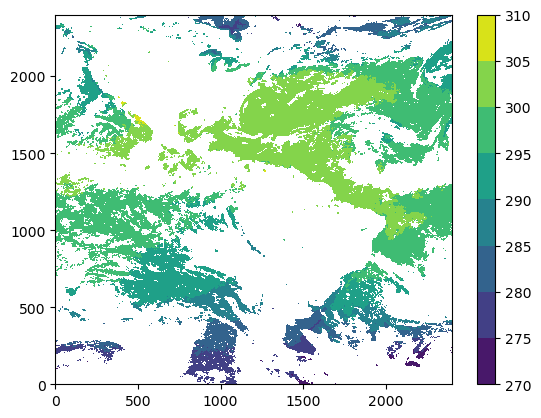

In [21]:
plt.contourf(sst)
plt.colorbar()

## References

netCDF4. Version 1.6.3. https://unidata.github.io/netcdf4-python/<br> 
Welcome to Pangeo at AOES. Making Maps using Cartopy. https://kpegion.github.io/Pangeo-at-AOES/examples/cartopy-tutorial.html<br>
